In [1]:
try:
  import pandas
except:
  !pip install pandas
  import pandas as pd
    
try:
  import numpy
except:
  !pip install numpy
  import numpy as np
    
try:
  import sklearn
except:
  !pip install scikit-learn
  import sklearn
    
try:
  import itertools
except:
  !pip install itertools

try:
  import torchmetrics
except:
  !pip install torchmetrics

try:
  import fnmatch
except:
  !pip install fnmatch

try:
  import seaborn
except:
  !pip install seaborn

In [2]:
from __future__ import print_function, division

import matplotlib
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

import torchvision.models.segmentation
import torchvision.transforms as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

# import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image

# from PIL import Image
from sklearn.model_selection import KFold, train_test_split
from scipy.stats import multivariate_normal

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset, Subset

from torch.distributions import multivariate_normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import normal

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import seaborn as sns

import sys
from torchmetrics.classification import AUROC
from sklearn import metrics
from itertools import cycle

from datetime import datetime
import fnmatch
from fnmatch import fnmatchcase
from PIL import Image

In [3]:
# Define the seeds

def set_seed(self, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    random_state_Kfold = seed
    
seed = 0
set_seed(seed)

In [4]:
# 创建保存路径
simu_warmup_fold = "./Simu/"
copula_fold = "./Copula/"

os.makedirs(simu_warmup_fold, exist_ok=True) # 存在路径则不创建也不报错
os.makedirs(copula_fold, exist_ok=True) # 存在路径则不创建也不报错

In [5]:
# <<<<<< 表示调参修改的项目 <<<<<<

work_id = 100  # <<<<<< 这个是每个调参工作的唯一识别码，所有输出也带他，保证每次训练记录的唯一性，输出是 ”WorkID?_...“形式 <<<<<<

# seed_list = [1,2] # <<<<<< 先用一个试试看
seed_list = [0]

k = 5   # <<<<<< KFOLD <<<<<<
batch_size = 16 # <<<<<< BATCH SIZE <<<<<<
num_epochs = 120 # <<<<<< EPOCH <<<<<<

# resnet_output_size = 128  # <<<<<< ResNet输出的向量的维度，原始ResNet是1000 <<<<<<

validation_split = 0.25
shuffle_train_set = True
train_ratio = 0.8

learning_rate = 0.01
lr_decay_step_size = 25
lr_decay_prop = 0.5

cudnn.benchmark = True
plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
width=height=224
width_raw=height_raw=512
#width=height=128

transformImg=tf.Compose([tf.ToPILImage(),
                         tf.Resize((height,width)),
                         tf.ToTensor(),
                         #tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                         #tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                         ]) # Set image transformation

In [7]:
df = pd.read_csv('./label-5228-corrected.csv')
filename = df['filename']

# Z = df[['gender','age','nct','k1','k2']]
Z = df[['gender','age']]
# Y = df[['al','high']]
Y = df[['al','se']]
al = df[['al']]
se = df[['se']]
high = df[['high']]
age = df[['age']]
gender = df[['gender']]
##########################################################
X_length = 2614
N_2623 = 5228

X_left_raw = torch.empty(X_length, 3,height_raw,width_raw)
X_right_raw = torch.empty(X_length, 3,height_raw,width_raw)
X_left = torch.empty(X_length, 3,height,width)
X_right = torch.empty(X_length, 3,height,width)

Age = torch.empty(X_length, 1)
Gender = torch.empty(X_length, 1)

Y_left_myopia= torch.empty(X_length, 1)
Y_right_myopia = torch.empty(X_length, 1)
Y_left_al = torch.empty(X_length, 1)
Y_left_se = torch.empty(X_length, 1)
Y_right_al = torch.empty(X_length, 1)
Y_right_se = torch.empty(X_length, 1)

##########################################################

YL = torch.empty((X_length,2))

# XL_2623 = torch.empty((2623 , 3 , XP,XQ))
# XL_2623_resize = torch.empty((2623, 3 ,height,width))

j=0
for i in range(0,X_length):
    if fnmatchcase(filename[j], '*-L*'):
        X_left_raw[i] = transforms.ToTensor()(Image.open('/root/data/'+filename[j]))
        X_left[i] = transformImg(X_left_raw[i])  
        Y_left_al[i] = torch.from_numpy(al.values[j])
        Y_left_se[i] = torch.from_numpy(se.values[j])
        Y_left_myopia[i] = torch.from_numpy(high.values[j])
        
        
        X_right_raw[i] = transforms.ToTensor()(Image.open('/root/data/'+filename[j+1]))
        X_right[i] = transformImg(X_right_raw[i])  
        Y_right_al[i] = torch.from_numpy(al.values[j+1])
        Y_right_se[i] = torch.from_numpy(se.values[j+1])
        Y_right_myopia[i] = torch.from_numpy(high.values[j+1])
        
        Age[i] = torch.from_numpy(age.values[j]) 
        Gender[i] = torch.from_numpy(gender.values[j]) 
        
        j = j + 2
    elif fnmatchcase(filename[j], '*-R*'):
        X_right_raw[i] = transforms.ToTensor()(Image.open('/root/data/'+filename[j]))
        X_right[i] = transformImg(X_right_raw[i])  
        Y_right_al[i] = torch.from_numpy(al.values[j])
        Y_right_se[i] = torch.from_numpy(se.values[j])
        Y_right_myopia[i] = torch.from_numpy(high.values[j])
        
        X_left_raw[i] = transforms.ToTensor()(Image.open('/root/data/'+filename[j+1]))
        X_left[i] = transformImg(X_left_raw[i])  
        Y_left_al[i] = torch.from_numpy(al.values[j+1])
        Y_left_se[i] = torch.from_numpy(se.values[j+1])
        Y_left_myopia[i] = torch.from_numpy(high.values[j+1])
        
        Age[i] = torch.from_numpy(age.values[j]) 
        Gender[i] = torch.from_numpy(gender.values[j]) 
        
        j = j + 2
    else:
        print(f"i: {i}")
        print(f"j: {j}")
        print("ERROR when creating X and Y!!!!!!!!!!!!")

ds_XL = TensorDataset(X_left.clone().detach().requires_grad_(True).float(),
                          X_right.clone().detach().requires_grad_(True).float(),
                          Age.clone().detach().requires_grad_(True).float(),
                          Gender.clone().detach().requires_grad_(True).float(),
                          torch.tensor(Y_left_myopia).float(),
                          torch.tensor(Y_right_myopia).float(),
                          torch.tensor(Y_left_al).float(),
                          torch.tensor(Y_left_se).float(),
                          torch.tensor(Y_right_al).float(),
                          torch.tensor(Y_right_se).float())

# ##########################################################
 # 输出生成的ds_XL供检查
data = []
for i in range(len(ds_XL)):
    sample = ds_XL[i]
    data.append([sample[0], sample[1], sample[2], sample[3],  sample[4], sample[5], sample[6],
                 sample[7], sample[8], sample[9]])

df = pd.DataFrame(data,
                  columns=["X_left", "X_right", "Age", "Gender",
                           "Y_left_myopia", "Y_right_myopia",
                           "Y_left_al", "Y_left_se", "Y_right_al", "Y_right_se"])
df.to_csv('TESTPREV.csv', index=False)


/tmp/ipykernel_194485/1531941244.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Y_left_myopia).float(),
/tmp/ipykernel_194485/1531941244.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Y_right_myopia).float(),
/tmp/ipykernel_194485/1531941244.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Y_left_al).float(),
/tmp/ipykernel_194485/1531941244.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requ

CorrMat of : 
[[ 1.         -0.02604322  0.2001752   0.20139696  0.01512817  0.20624934
   0.20269001  0.02078098]
 [-0.02604322  1.          0.24679278  0.0998037   0.08270715  0.25640682
   0.11994489  0.08054812]
 [ 0.2001752   0.24679278  1.          0.84962481  0.51540738  0.89670501
   0.75867083  0.44755521]
 [ 0.20139696  0.0998037   0.84962481  1.          0.64105531  0.76045156
   0.88172984  0.54126014]
 [ 0.01512817  0.08270715  0.51540738  0.64105531  1.          0.44870854
   0.55030855  0.6788448 ]
 [ 0.20624934  0.25640682  0.89670501  0.76045156  0.44870854  1.
   0.85451286  0.5061234 ]
 [ 0.20269001  0.11994489  0.75867083  0.88172984  0.55030855  0.85451286
   1.          0.6209762 ]
 [ 0.02078098  0.08054812  0.44755521  0.54126014  0.6788448   0.5061234
   0.6209762   1.        ]]
Mean of: 
Age               27.551645
Gender             0.229151
Y_left_al         27.577996
Y_left_se         10.092626
Y_left_myopia      0.718057
Y_right_al        27.635583
Y_right_

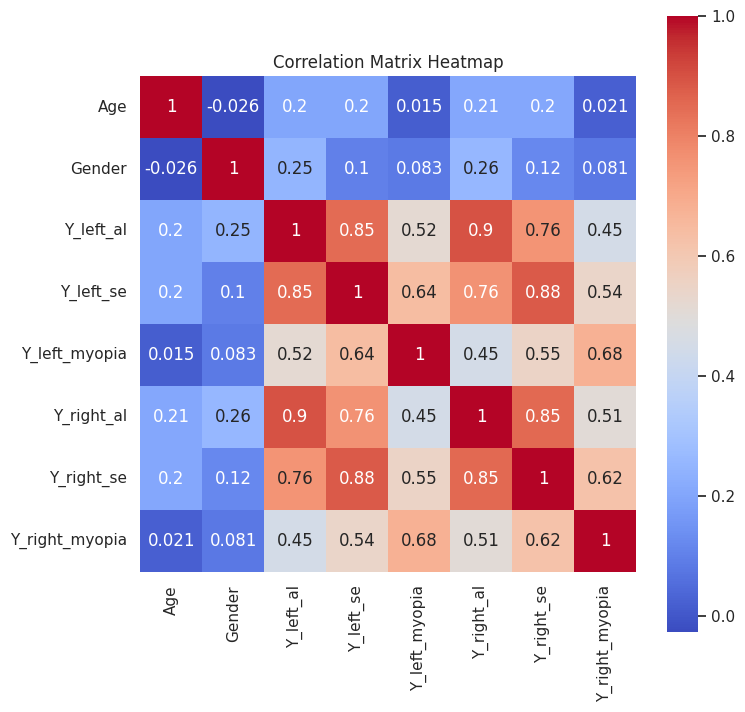

In [8]:
# 检查并调试 左右眼 al se myopia 之间的相关性
pd.set_option('display.max_columns', None)  # Set maximum number of columns to display
pd.set_option('display.max_colwidth', None)  # Set column width to display
df_respones = df[["Age", "Gender",
                  "Y_left_al", "Y_left_se", "Y_left_myopia", "Y_right_al", "Y_right_se", "Y_right_myopia"]]
# print(df_respones)
df_numeric = df_respones.applymap(lambda x:
                         x.detach().flatten().numpy()[0] if isinstance(x, torch.Tensor) else x) # convert each tensor item to a 1D array (numpy array)
correlation_matrix = np.corrcoef(df_numeric, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix, columns=df_respones.columns, index=df_respones.columns)
print('CorrMat of : '); print(correlation_matrix)


# 查看各列的均值
# print("Mean of: "); print(df.mean(numeric_only=True))
print("Mean of: "); print(df[df_respones.columns].mean())

# Plot the corr heatmap
sns.set()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap")
plt.savefig(simu_warmup_fold + f"WorkID{work_id}_Simu_heatmap.png") # Save the plot to an image file

# 存储数据集
PATH_ds = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_ds_XL_Data_seed{seed}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.pt'
torch.save(ds_XL, PATH_ds)

In [9]:
class rsn10_adapter (nn.Module):
    def __init__(self , num_classes=[2,2]):
        super(rsn10_adapter, self).__init__()
        
        nb_tasks = len(num_classes)
        
        
        self.conv1 = models.resnet18().conv1
        self.bn1=models.resnet18().bn1
        self.relu=models.resnet18().relu
        self.maxpool=models.resnet18().maxpool
        
        self.adapter1_0=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter1_1=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter1_2=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter1_3=nn.ModuleList([nn.Conv2d(64,64, kernel_size=1, padding=0) for i in range(nb_tasks)])
        
        
        self.adapter2_0=nn.ModuleList([nn.Conv2d(64,128, kernel_size=1, padding=0, stride=2) for i in range(nb_tasks)])
        self.adapter2_1=nn.ModuleList([nn.Conv2d(128,128, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter2_2=nn.ModuleList([nn.Conv2d(128,128, kernel_size=1, padding=0) for i in range(nb_tasks)])
        self.adapter2_3=nn.ModuleList([nn.Conv2d(128,128, kernel_size=1, padding=0) for i in range(nb_tasks)])
        
        # self.adapter3_0=nn.Conv2d(128,256, kernel_size=1, padding=0, stride=2)
        # self.adapter3_1=nn.Conv2d(256,256, kernel_size=1, padding=0)
        # self.adapter3_2=nn.Conv2d(256,256, kernel_size=1, padding=0)
        # self.adapter3_3=nn.Conv2d(256,256, kernel_size=1, padding=0)
        
        # self.adapter4_0=nn.Conv2d(256,512, kernel_size=1, padding=0, stride=2)
        # self.adapter4_1=nn.Conv2d(512,512, kernel_size=1, padding=0)
        # self.adapter4_2=nn.Conv2d(512,512, kernel_size=1, padding=0)
        # self.adapter4_3=nn.Conv2d(512,512, kernel_size=1, padding=0)

        self.layer1=models.resnet18().layer1
        self.layer2=models.resnet18().layer2
        # self.layer3=models.resnet18().layer3
        # self.layer4=models.resnet18().layer4
        self.avgpool=models.resnet18().avgpool
        #nn.init.xavier_uniform_(self.adapter1.weight, gain=0.01)
        #nn.init.xavier_uniform_(self.adapter2.weight, gain=0.01)
        #nn.init.xavier_uniform_(self.adapter3.weight, gain=0.01)
        #nn.init.xavier_uniform_(self.adapter4.weight, gain=0.01)

        # self.fc=models.resnet18().fc
        self.fc=nn.Linear(128, 2)
        
    def forward(self, x):
        y_vec = torch.tensor([]).to(device)
        
        for i in range(2):
            # print("i: ", i)
            task = i
            x_i = x[i]
            
            # print("x_i:", x_i)
            
            
            x_i = self.conv1(x_i)
            x_i = self.bn1(x_i)
            x_i = self.relu(x_i)
            x_i = self.maxpool(x_i)
            
            residual=x_i
            x_i = self.layer1[0].conv1(x_i) + self.adapter1_0[task](x_i)
            x_i = self.layer1[0].bn1(x_i)
            x_i = self.layer1[0].relu(x_i)
            x_i = self.layer1[0].conv2(x_i) + self.adapter1_1[task](x_i)
            x_i = self.layer1[0].bn2(x_i)
            x_i = x_i + residual
            x_i = self.layer1[0].relu(x_i)
            
            residual=x_i
            x_i = self.layer1[1].conv1(x_i) + self.adapter1_2[task](x_i)
            x_i = self.layer1[1].bn1(x_i)
            x_i = self.layer1[1].relu(x_i)
            x_i = self.layer1[1].conv2(x_i) + self.adapter1_3[task](x_i)
            x_i = self.layer1[1].bn2(x_i)
            x_i = x_i + residual
            x_i = self.layer1[1].relu(x_i)
            
            
            residual=x_i
            x_i = self.layer2[0].conv1(x_i) + self.adapter2_0[task](x_i)
            x_i = self.layer2[0].bn1(x_i)
            x_i = self.layer2[0].relu(x_i)
            x_i = self.layer2[0].conv2(x_i) + self.adapter2_1[task](x_i)
            x_i = self.layer2[0].bn2(x_i)
            residual = self.layer2[0].downsample(residual)
            x_i = x_i + residual
            x_i = self.layer2[0].relu(x_i)
            
            residual=x_i
            x_i = self.layer2[1].conv1(x_i) + self.adapter2_2[task](x_i)
            x_i = self.layer2[1].bn1(x_i)
            x_i = self.layer2[1].relu(x_i)
            x_i = self.layer2[1].conv2(x_i) + self.adapter2_3[task](x_i)
            x_i = self.layer2[1].bn2(x_i)
            x_i = x_i + residual
            x_i = self.layer2[1].relu(x_i)
            
            
            # residual=x_i
            # x_i = self.layer3[0].conv1(x_i) + self.adapter3_0(x_i)
            # x_i = self.layer3[0].bn1(x_i)
            # x_i = self.layer3[0].relu(x_i)
            # x_i = self.layer3[0].conv2(x_i) + self.adapter3_1(x_i)
            # x_i = self.layer3[0].bn2(x_i)
            # residual = self.layer3[0].downsample(residual)
            # x_i = x_i + residual
            # x_i = self.layer3[0].relu(x_i)
            
            # residual=x_i
            # x_i = self.layer3[1].conv1(x_i) + self.adapter3_2(x_i)
            # x_i = self.layer3[1].bn1(x_i)
            # x_i = self.layer3[1].relu(x_i)
            # x_i = self.layer3[1].conv2(x_i) + self.adapter3_3(x_i)
            # x_i = self.layer3[1].bn2(x_i)
            # x_i = x_i + residual
            # x_i = self.layer3[1].relu(x_i)
            
            
            # residual=x_i
            # x_i = self.layer4[0].conv1(x_i) + self.adapter4_0(x_i)
            # x_i = self.layer4[0].bn1(x_i)
            # x_i = self.layer4[0].relu(x_i)
            # x_i = self.layer4[0].conv2(x_i) + self.adapter4_1(x_i)
            # x_i = self.layer4[0].bn2(x_i)
            # residual = self.layer4[0].downsample(residual)
            # x_i = x_i + residual
            # x_i = self.layer4[0].relu(x_i)
            
            # residual=x_i
            # x_i = self.layer4[1].conv1(x_i) + self.adapter4_2(x_i)
            # x_i = self.layer4[1].bn1(x_i)
            # x_i = self.layer4[1].relu(x_i)
            # x_i = self.layer4[1].conv2(x_i) + self.adapter4_3(x_i)
            # x_i = self.layer4[1].bn2(x_i)
            # x_i = x_i + residual
            # x_i = self.layer4[1].relu(x_i)
            
            x_i = self.avgpool(x_i)
            x_i = x_i.view(x_i.size(0), -1)
            x_i = self.fc(x_i)
            
            # print("x_i final :", x_i)
            y_vec = torch.cat((y_vec,x_i), -1)
            # print(y_vec)
        return y_vec[:,0:2] , y_vec[:,2:4]  

In [10]:
# get_test_loss
def get_test_loss(net, criterion_regression, data_loader):
    """Object: Monitor during training procedure, use traditional loss
       Input: net,
              criterion_classification,
              criterion_regression,
              data_loader: 注意输入数据的结构顺序不能变
       Output: loss_summary: a dictionary:
                    "avg_loss_left_classification"
                    "avg_loss_right_classification"
                    "avg_loss_left_regression"
                    "avg_loss_right_regression"
                    "avg_loss_left"
                    "avg_loss_right"
                    "avg_loss_classification"
                    "avg_loss_regression"
                    "avg_loss"
    """
    testing_loss_left_SE = [] # by bce
    testing_loss_right_SE = []
    testing_loss_left_AL = [] # by mse
    testing_loss_right_AL = []

    net.eval()

    with torch.no_grad():
        for data in data_loader:
            # Load data from loader (below 6 lines)
            X_left, X_right, age, gender, *labels= data
            inputs = X_left, X_right

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device)
            labels_right_SE = labels[5].squeeze().to(device)
            labels_left_AL = labels[2].squeeze().to(device)
            labels_right_AL = labels[4].squeeze().to(device)

            # Get and separate outputs
            outputs_left, outputs_right = net(inputs)
            outputs_left_SE = outputs_left[:, 0]
            outputs_right_SE = outputs_right[:, 0]
            outputs_left_AL = outputs_left[:, 1]
            outputs_right_AL = outputs_right[:, 1]

            # Cal loss
            loss_left_SE = criterion_regression(outputs_left_SE, labels_left_SE) # 不用reduce="none"，直接计算mean
            loss_right_SE = criterion_regression(outputs_right_SE, labels_right_SE)
            loss_left_AL = criterion_regression(outputs_left_AL, labels_left_AL)
            loss_right_AL = criterion_regression(outputs_right_AL, labels_right_AL)

            # # Agg loss by row, col and total
            # loss_left = loss_left_classification + loss_left_regression
            # loss_right = loss_right_classification + loss_right_regression
            # loss_classification = loss_left_classification + loss_right_classification
            # loss_regression = loss_left_regression + loss_right_regression
            # loss = loss_left + loss_right

            # Record loss elements
            testing_loss_left_SE.append(loss_left_SE)
            testing_loss_right_SE.append(loss_right_SE)
            testing_loss_left_AL.append(loss_left_AL)
            testing_loss_right_AL.append(loss_right_AL)
            
    # Cal the avg loss for each loss element
    avg_loss_left_SE = torch.mean(torch.stack(testing_loss_left_SE)) # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_SE = torch.mean(torch.stack(testing_loss_right_SE)) # 同上
    avg_loss_left_AL = torch.mean(torch.stack(testing_loss_left_AL)) # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_AL =torch.mean(torch.stack(testing_loss_right_AL)) # 同上

    # Agg loss by row, col and total
    avg_loss_left = avg_loss_left_SE + avg_loss_left_AL
    avg_loss_right = avg_loss_right_SE + avg_loss_right_AL
    avg_loss_SE = avg_loss_left_SE + avg_loss_right_SE
    avg_loss_AL = avg_loss_left_AL + avg_loss_right_AL
    avg_loss = avg_loss_SE + avg_loss_AL # avg loss per item

    # Arrange the output
    loss_summary = {"avg_loss_left_SE": avg_loss_left_SE,
                    "avg_loss_right_SE": avg_loss_right_SE,
                    "avg_loss_left_AL": avg_loss_left_AL,
                    "avg_loss_right_AL": avg_loss_right_AL,
                    "avg_loss_left": avg_loss_left,
                    "avg_loss_right": avg_loss_right,
                    "avg_loss_SE": avg_loss_SE,
                    "avg_loss_AL": avg_loss_AL,
                    "avg_loss": avg_loss}

    # plt.plot(torch.tensor(testing_loss_left_classification, device = 'cpu'), label="testing_loss_left_classification")
    # plt.xlabel('Iteration')
    # plt.ylabel("testing_loss_left_classification")
    # plt.legend()
    # plt.show()

    return loss_summary

In [11]:
# test_stage
def test_stage(net,  criterion_regression, test_loader):
    # For AUC
    correct_classification_left = 0
    correct_classification_right = 0
    total_classification_times = 0

    # For MSE and BCE
    testing_loss_left_SE = []  # by bce
    testing_loss_right_SE = []
    testing_loss_left_AL = []  # by mse
    testing_loss_right_AL = []

    # For ROC
    y_left_test = []
    y_right_test = []
    y_left_score = []
    y_right_score = []

    net.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            # Load data from loader (below 4 lines)
            X_left, X_right, age, gender, *labels = data
            inputs = X_left, X_right

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device)
            labels_right_SE = labels[5].squeeze().to(device)
            labels_left_AL = labels[2].squeeze().to(device)
            labels_right_AL = labels[4].squeeze().to(device)

            # Get and separate outputs
            outputs_left, outputs_right = net(inputs)
            outputs_left_SE = outputs_left[:, 0]
            outputs_right_SE = outputs_right[:, 0]
            outputs_left_AL = outputs_left[:, 1]
            outputs_right_AL = outputs_right[:, 1]

            # Cal loss
            # print("outputs_left_classification: ", outputs_left_classification)
            # print("labels_left_classification: ", labels_left_classification)
            loss_left_SE = criterion_regression(outputs_left_SE, labels_left_SE)  # 不用reduce="none"，直接计算mean
            loss_right_SE = criterion_regression(outputs_right_SE, labels_right_SE)
            loss_left_AL = criterion_regression(outputs_left_AL, labels_left_AL)
            loss_right_AL = criterion_regression(outputs_right_AL, labels_right_AL)

            # Record loss elements
            testing_loss_left_SE.append(loss_left_SE)
            testing_loss_right_SE.append(loss_right_SE)
            testing_loss_left_AL.append(loss_left_AL)
            testing_loss_right_AL.append(loss_right_AL)

            

    # Cal the avg loss for each loss element
    avg_loss_left_SE = torch.mean(torch.stack(testing_loss_left_SE))  # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_SE = torch.mean(torch.stack(testing_loss_right_SE))  # 同上
    avg_loss_left_AL = torch.mean(torch.stack(testing_loss_left_AL))  # 这个没错，batch内部已经是平均值了，现在只要list的均值
    avg_loss_right_AL = torch.mean(torch.stack(testing_loss_right_AL))  # 同上

    # Agg loss by row, col and total
    avg_loss_left = avg_loss_left_SE + avg_loss_left_AL
    avg_loss_right = avg_loss_right_SE + avg_loss_right_AL
    avg_loss_SE = avg_loss_left_SE + avg_loss_right_SE
    avg_loss_AL = avg_loss_left_AL + avg_loss_right_AL
    avg_loss = avg_loss_SE + avg_loss_AL # avg loss per item

    # Arrange the output
    loss_summary = {"avg_loss_left_SE": avg_loss_left_SE,
                    "avg_loss_right_SE": avg_loss_right_SE,
                    "avg_loss_left_AL": avg_loss_left_AL,
                    "avg_loss_right_AL": avg_loss_right_AL,
                    "avg_loss_left": avg_loss_left,
                    "avg_loss_right": avg_loss_right,
                    "avg_loss_SE": avg_loss_SE,
                    "avg_loss_AL": avg_loss_AL,
                    "avg_loss": avg_loss}

    print('-' * 100)
    print("Performance of the BEST parameter setting on TEST set:")
    for key, val in loss_summary.items():
        if torch.is_tensor(val):
            val = val.item()
        print("\t {}: {}".format(key, val))

    return loss_summary




In [12]:
# 我们添加的函数，用来计算运行/剩余时
def format_time(seconds):
    """Formats the time in seconds into a string of hours, minutes, and seconds."""
    hours = int(seconds) // 3600
    minutes = (int(seconds) % 3600) // 60
    seconds = int(seconds) % 60
    return f'{hours:02d}h {minutes:02d}m {seconds:02d}s'

def print_training_progress(epoch, total_epochs, time_elapsed, kfold, present_fold):
    """Prints the training progaress including estimated total training time, time used, and estimated time left."""
    estimated_total_time = time_elapsed * ((total_epochs * kfold) / (total_epochs * fold + (epoch + 1)))
    time_used = format_time(time_elapsed)
    time_left = format_time(estimated_total_time - time_elapsed)
    total_training_time = format_time(estimated_total_time)

#     print(f'Epoch [{epoch+1}/{total_epochs}]')
    print(f'Time used: {time_used: >32}')
    print(f'Estimated time left: {time_left: >22}')
    print(f'Estimated total training time: {total_training_time: >12}')

# place to print time summary
# print_training_progress(epoch, num_epochs, time.time() - since, kfold, present_fold)

In [13]:
# Train model
def train_model(model, criterion_regression, optimizer, scheduler, dl_train, dl_val, dl_test,
                num_epochs):
    """Object:
       Input: model: 就是net，你构造的需要训练的网络
              criterion_classification:
              criterion_regression:
              optimizer: 实例化的一个优化器
              scheduler:
              dl_train:
              dl_val:
              num_epochs:
    """

    best_model_wts = copy.deepcopy(model.state_dict())  # 存储最佳参数
    least_loss = 10000000.0  # 存储最小损失
    best_epoch_num = 0  # 存储? # TODO
    val_loss = []  # return of get_test_loss per 20 batch
    n_train = int(len(dl_train))  # loader的长度，注意不是图片的张数，要翻倍

    # For plot
    train_loss_batchwise = []
    val_loss_batchwise = []
    test_loss_batchwise = []

    # Loop epoch
    for epoch in range(num_epochs):  # [0, num_epochs-1]
        # Report learning rate change if happened
        if epoch % exp_lr_scheduler.state_dict()['step_size'] == 0:
            print(">" * 30 + " Learning rate is to {} now.".format(
                exp_lr_scheduler.state_dict()['_last_lr'][0]) + "<" * 30)
        print('-' * 100)
        print(f'Epoch {epoch + 1}/{num_epochs}')

        model.train()

        running_loss = 0.0
        running_loss_temp = 0.0

        # Loop train data in one epoch
        for i, data in enumerate(dl_train, 0):  # i 从0开始
            # Load data from loader (below 4 lines)
            X_left, X_right, age, gender, *labels = data
            inputs = X_left, X_right, age, gender

            # get the data to GPU (if available)
            inputs = [_data.to(device) for _data in inputs]
            labels = [_label.to(device) for _label in labels]

            # Separate labels
            labels_left_SE = labels[3].squeeze().to(device)
            labels_right_SE = labels[5].squeeze().to(device)
            labels_left_AL = labels[2].squeeze().to(device)
            labels_right_AL = labels[4].squeeze().to(device)

            # 训练过程
            # 反向传播之前初始化梯度就行，这里我们放在最前面
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                # 前向传播
                outputs_left, outputs_right = model(inputs)
                outputs_left_SE = outputs_left[:, 0]
                outputs_right_SE = outputs_right[:, 0]
                outputs_left_AL = outputs_left[:, 1]
                outputs_right_AL = outputs_right[:, 1]

                # # Loss function，注意保持梯度的传递，
                # loss_classification = criterion_classification(outputs_classification, labels_classification)
                # loss_regression = criterion_regression(outputs_regression, labels_regression)
                # loss = loss_classification + loss_regression
                # 上述做法不可行，左右眼取了均值而不是相加！

                # Cal loss elementwise
                loss_left_SE = criterion_regression(outputs_left_SE, labels_left_SE)  # 不用reduce="none"，直接计算mean
                loss_right_SE = criterion_regression(outputs_right_SE, labels_right_SE)
                loss_left_AL = criterion_regression(outputs_left_AL, labels_left_AL)
                loss_right_AL = criterion_regression(outputs_right_AL, labels_right_AL)

                # Agg element loss by row, col and total
                loss = loss_left_SE + loss_right_SE + loss_left_AL + loss_right_AL

                # 反向传播
                loss.backward()
                # 更新
                optimizer.step()

            running_loss += loss.item()  # 记录每个epoch的平均loss
            running_loss_temp += loss.item()  # 记录每20个batch的累计loss

            if i % 20 == 19:
                # record train/val/test loss per 20 batch for plot
                # train_loss_summary = get_test_loss(model, criterion_classification, criterion_regression, dl_train)
                val_loss_summary = get_test_loss(model,  criterion_regression, dl_val)
                # test_loss_summary = get_test_loss(model, criterion_classification, criterion_regression, dl_test)

                # 下方使用item，把cuda里的tensor的数值部分提取到cpu里，这种方法比什么tensor.to("cpu")来得直接
                # train_loss_batchwise.append(train_loss_summary["avg_loss"].item())
                # # avg_val_loss_cla_reg_sum = get_test_loss(model, criterion_classification, criterion_regression, dl_val)
                # val_loss_batchwise.append(val_loss_summary["avg_loss"].item())
                # test_loss_batchwise.append(test_loss_summary["avg_loss"].item())
                avg_val_loss_l_r_cla_reg_sum = [val_loss_summary["avg_loss_left"],
                                                val_loss_summary["avg_loss_right"],
                                                val_loss_summary["avg_loss_SE"],
                                                val_loss_summary["avg_loss_AL"],
                                                val_loss_summary["avg_loss"]]

                avg_loss_str = ' '.join(f'{value:.3f}' for value in avg_val_loss_l_r_cla_reg_sum)
                # Avg train loss past 20 batch: the mean of train losses of model during past 20 batch
                # Val LRClaRegTot loss this batch: the Left, Right, Classification, Regression, and Total loss of model with parameter attained in this batch on val set
                print(
                    f'[Num of batch: {i + 1:2d}] Avg train loss past 20 batch: {running_loss_temp / 20 :.3f} | Val LRClaRegTot loss this batch: {avg_loss_str} ')  # Epoch: {epoch + 1},
                # print(f'\t Train loss this batch: {train_loss_batchwise :.3f}') # <<<<<< 和 Val tot loss this batch 相对于的
                running_loss_temp = 0.0

        # 每个epoch结束时计算三个loss，输出，并在之后用来画loss plot
        # 下方使用item，把cuda里的tensor的数值部分提取到cpu里，这种方法比什么tensor.to("cpu")来得直接
        train_loss_summary = get_test_loss(model,  criterion_regression, dl_train)
        val_loss_summary = get_test_loss(model,  criterion_regression, dl_val)
        test_loss_summary = get_test_loss(model,  criterion_regression, dl_test)
                
        train_loss_batchwise.append(train_loss_summary["avg_loss"].item())
        # avg_val_loss_cla_reg_sum = get_test_loss(model, criterion_classification, criterion_regression, dl_val)
        val_loss_batchwise.append(val_loss_summary["avg_loss"].item())
        test_loss_batchwise.append(test_loss_summary["avg_loss"].item())
        
        print("-"*20)
        print("Train loss this batch: ", train_loss_summary["avg_loss"].item())
        print("Val loss this batch:   ", val_loss_summary["avg_loss"].item())
        print("Test loss this batch:  ", test_loss_summary["avg_loss"].item())
        print("-"*20)
                
        # ##################################### TEST BEGIN ######################################
        # print("oucopula.fc_cla.weight.data: ", oucopula.fc_cla.weight.data)
        # print("oucopula.fc_reg.weight.data: ", oucopula.fc_reg.weight.data)
        # print("oucopula.resnetl.model_resnet.conv1.weight.data: ", oucopula.resnetl.model_resnet.conv1.weight.data)
        # ###################################### TEST END #######################################

        scheduler.step()  # 放在epoch循环里

        # epoch_loss = running_loss / n_train  # Set to 0 per epoch # 这里计算无误
        # # Avg train loss in this epoch: the mean of train losses of model during this epoch
        # print(f'Avg train loss in this epoch: {epoch_loss:.4f}')
        # print("n_train: ", n_train)

        # Cal and record best model over val set over epoches
        # 这边只能使用val_dataset，不能使用test set，test是用来检验此处挑选出的模型的
        avg_val_loss_this_epoch = get_test_loss(model,  criterion_regression, dl_val)["avg_loss"]

        if avg_val_loss_this_epoch < least_loss: # 使用val loss选择最优模型
            least_loss = avg_val_loss_this_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch_num = epoch

        # place to print time summary
        print_training_progress(epoch, num_epochs, time.time() - since, k, fold)
        print()
        
        # ====== This is the end of code within a epoch ======#

    # Load the BEST model when the training process for all epoches is ended
    model.load_state_dict(best_model_wts)

    avg_train_loss_best_model = get_test_loss(model,  criterion_regression, dl_train)["avg_loss"]
    avg_val_loss_best_model = get_test_loss(model,  criterion_regression, dl_val)["avg_loss"]
    avg_test_loss_best_model = get_test_loss(model,  criterion_regression, dl_test)["avg_loss"]

    # Evaluate the BEST model
    print('-' * 100)
    print("Evaluate the best parameter setting acquired in this fold: ")
    print("\t Best setting acquired in Epoch: {}/{}".format(best_epoch_num + 1, num_epochs))
    print("\t Avg loss on train set: {:.3f}".format(avg_train_loss_best_model))
    print("\t Avg loss on validation set: {:.3f}".format(avg_val_loss_best_model))
    print("\t Avg loss on test set: {:.3f}".format(avg_test_loss_best_model))

    return model, train_loss_batchwise, val_loss_batchwise, test_loss_batchwise

In [14]:
def plot_loss(batch_num_per_epoch, train_loss, val_loss, test_loss):
    plt.figure(figsize=(50, 30))
    x = range(1, len(train_loss) + 1)
    xticks = range(1, len(train_loss) + 1, 2)
    
    plt.plot(x, train_loss, label='Train Loss')
    plt.plot(x, val_loss, label='Validation Loss')
    plt.plot(x, test_loss, label='Test Loss')
    
    plt.xticks(xticks, fontsize=12)
    plt.xlabel('Per 20 Epochs')
    plt.ylabel('Loss')
    plt.title('Itemwise Loss Per 20 Batch')
    plt.legend()
    plt.savefig(f'./Simu/WorkID{work_id}_Simu_LossPlot_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.png')
    plt.show()

In [15]:
# ########### config_task.py ###########
# # File allowing to change which task is currently used for training/testing
# config_task = 0
# mode = 'parallel_adapters' #'normal'
# proj = '11'
# config_factor = 1.

# isdropout1 = False
# isdropout2 = True

# # left_or_right = 0

# ########### config_task.py ###########

    ooo  u   u  ccc   ooo  pppp  u   u l      a
  o   o u   u c     o   o p   p u   u l      a a
 o   o u   u c     o   o pppp  u   u l     aaaaa
 ooo   uuu   ccc   ooo  p      uuu  llll a     a
WorkID: 100
This experiment started at: 2023-12-06 22:23:02
Important parameters: 
	Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
	Pytorch version:  2.0.0+cu118
	Batch num per epoch:  98
	learning_rate:  0.01
	Learning rate decay every 25 epoches.
Other parameters: 
	Random state KFold:  0
	Seed:  0
	KFold:  5
	Batch size:  16
	Number of epochs:  120
	Sample size:  2614
	shuffle_train_set:  True
	train_ratio (prop of train+val):  0.8
	validation_split:  0.25

Fold 1
train_idx:  [ 0  1  2  3  5  6  7  8 11 12 13 15 16 17 18 19 20 21 24 25]
test_idx:  [  4   9  10  14  22  23  27  33  37  39  41  53  57  69  70  76  92  98
 104 109]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.01 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------

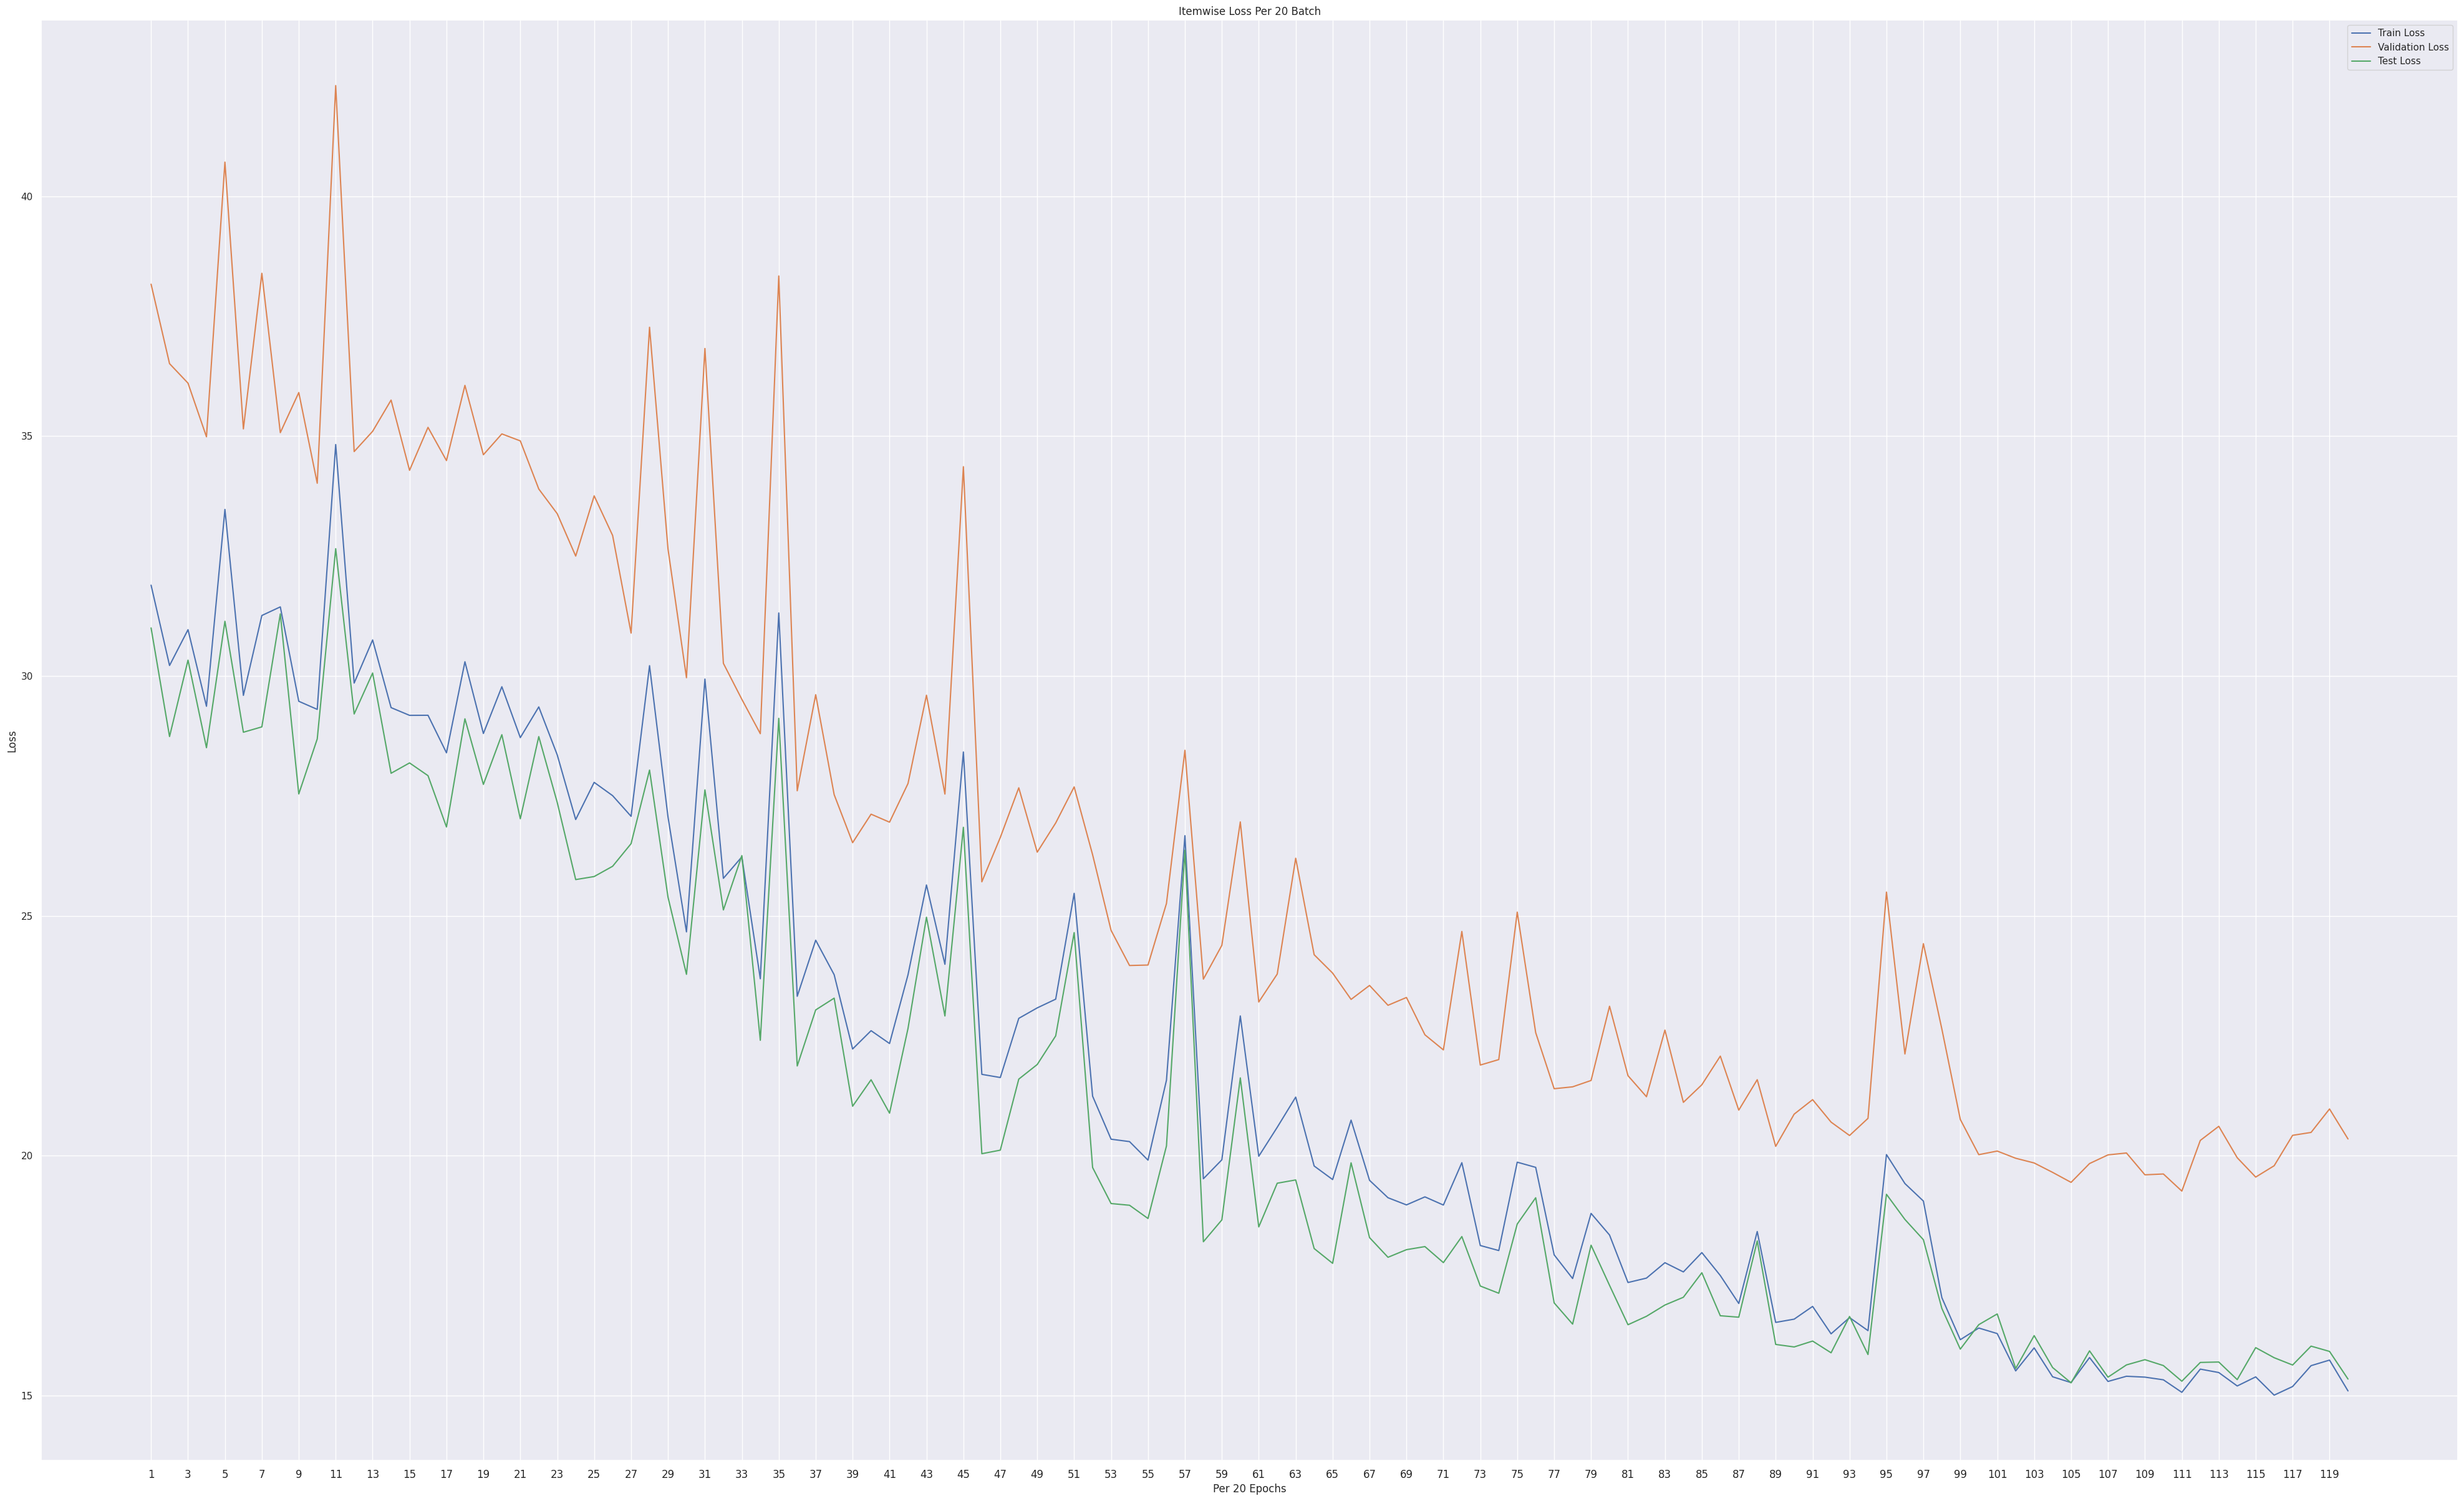

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_loss_left_SE: 6.114322662353516
	 avg_loss_right_SE: 6.360319137573242
	 avg_loss_left_AL: 1.379141092300415
	 avg_loss_right_AL: 1.4443650245666504
	 avg_loss_left: 7.493463516235352
	 avg_loss_right: 7.804684162139893
	 avg_loss_SE: 12.474641799926758
	 avg_loss_AL: 2.8235061168670654
	 avg_loss: 15.298148155212402
Fold 2
train_idx:  [ 0  2  3  4  5  7  8  9 10 12 13 14 16 19 20 21 22 23 24 25]
test_idx:  [ 1  6 11 15 17 18 30 31 34 40 43 47 48 52 58 61 64 77 80 85]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.01 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/120
[Num of batch: 20] Avg train loss past 20 batch: 527.303 | Val LRClaRegTot loss this batch: 44.599 59.307 23.943 79.963 103.906 
[Num of batch: 40] Avg train los

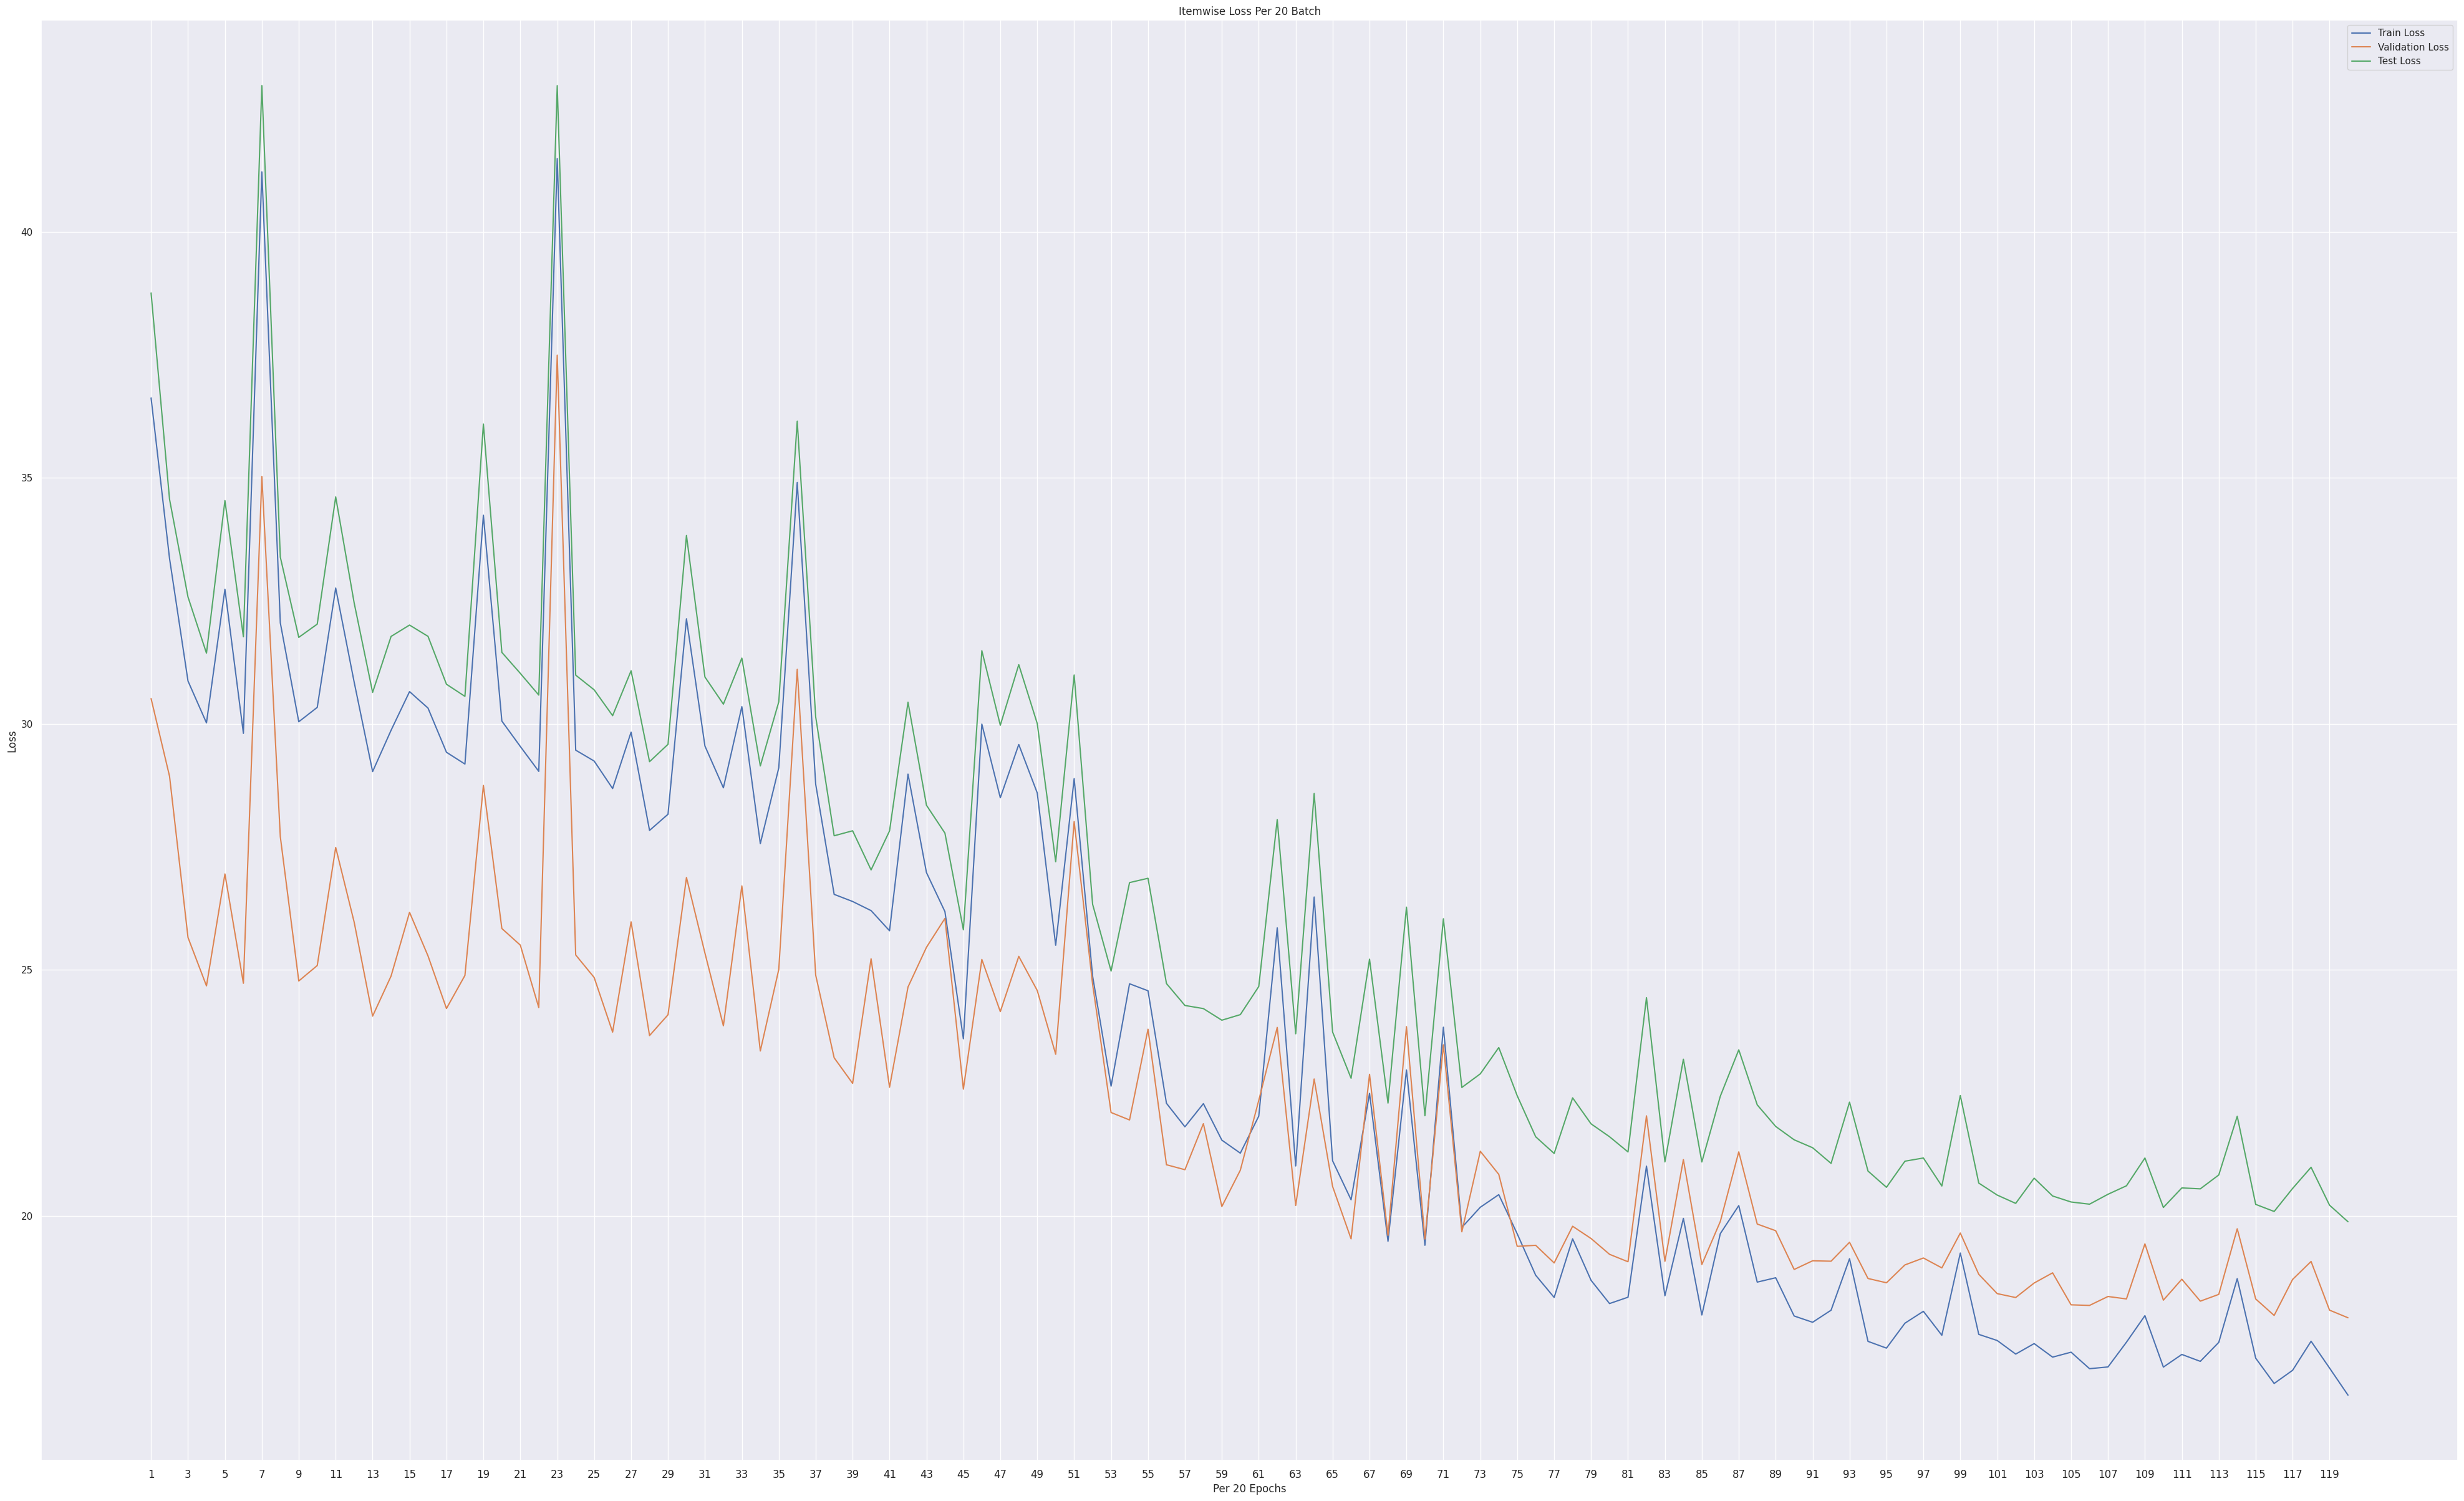

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_loss_left_SE: 8.356892585754395
	 avg_loss_right_SE: 7.915793418884277
	 avg_loss_left_AL: 1.740233302116394
	 avg_loss_right_AL: 1.8684437274932861
	 avg_loss_left: 10.097126007080078
	 avg_loss_right: 9.784236907958984
	 avg_loss_SE: 16.272686004638672
	 avg_loss_AL: 3.6086769104003906
	 avg_loss: 19.881362915039062
Fold 3
train_idx:  [ 0  1  3  4  6  7  9 10 11 12 14 15 17 18 20 21 22 23 24 25]
test_idx:  [ 2  5  8 13 16 19 29 32 35 36 42 45 49 54 55 56 60 65 66 68]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.01 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/120
[Num of batch: 20] Avg train loss past 20 batch: 545.044 | Val LRClaRegTot loss this batch: 22.540 21.352 26.101 17.791 43.892 
[Num of batch: 40] Avg train los

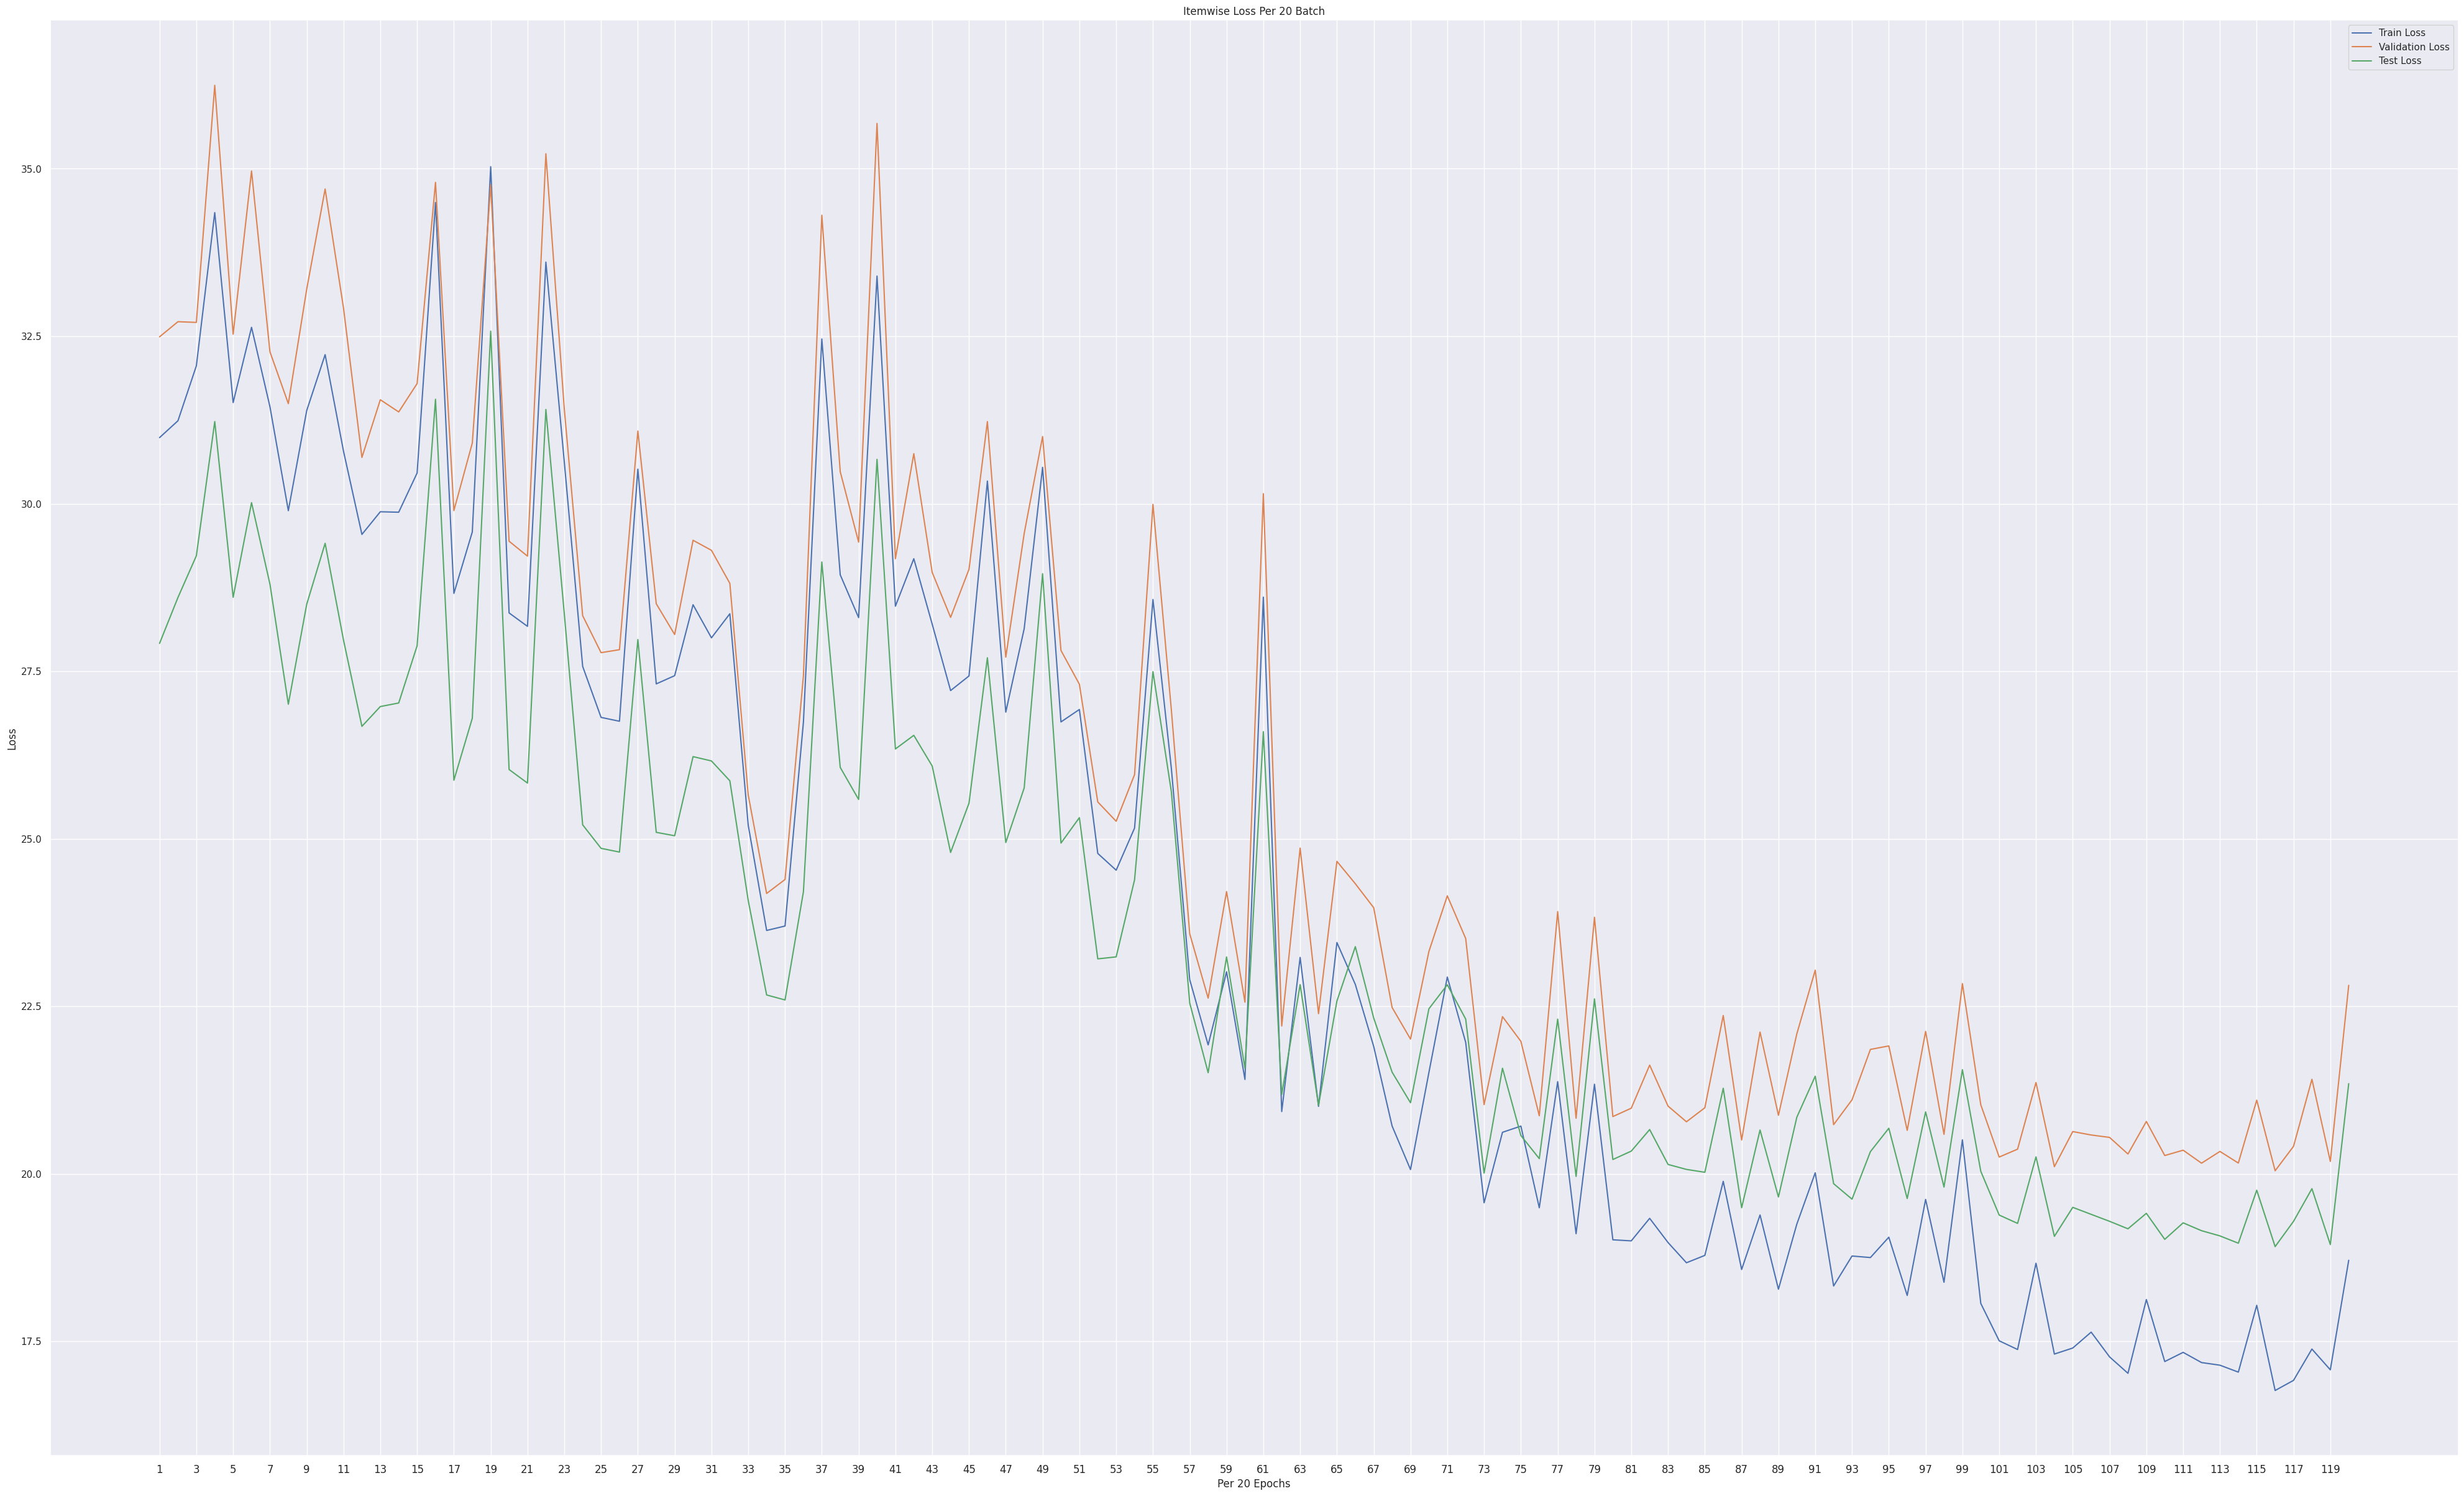

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_loss_left_SE: 7.978784561157227
	 avg_loss_right_SE: 7.151170253753662
	 avg_loss_left_AL: 2.0075795650482178
	 avg_loss_right_AL: 1.7779524326324463
	 avg_loss_left: 9.986364364624023
	 avg_loss_right: 8.929122924804688
	 avg_loss_SE: 15.129955291748047
	 avg_loss_AL: 3.785531997680664
	 avg_loss: 18.91548728942871
Fold 4
train_idx:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 21]
test_idx:  [ 12  20  28  38  44  46  50  51  59  62  74  78  79  81  83  88  90  95
  97 101]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.01 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/120
[Num of batch: 20] Avg train loss past 20 batch: 461.156 | Val LRClaRegTot loss this batch: 34.300 32.907 45.276 21.931 67.207 
[Num of batch

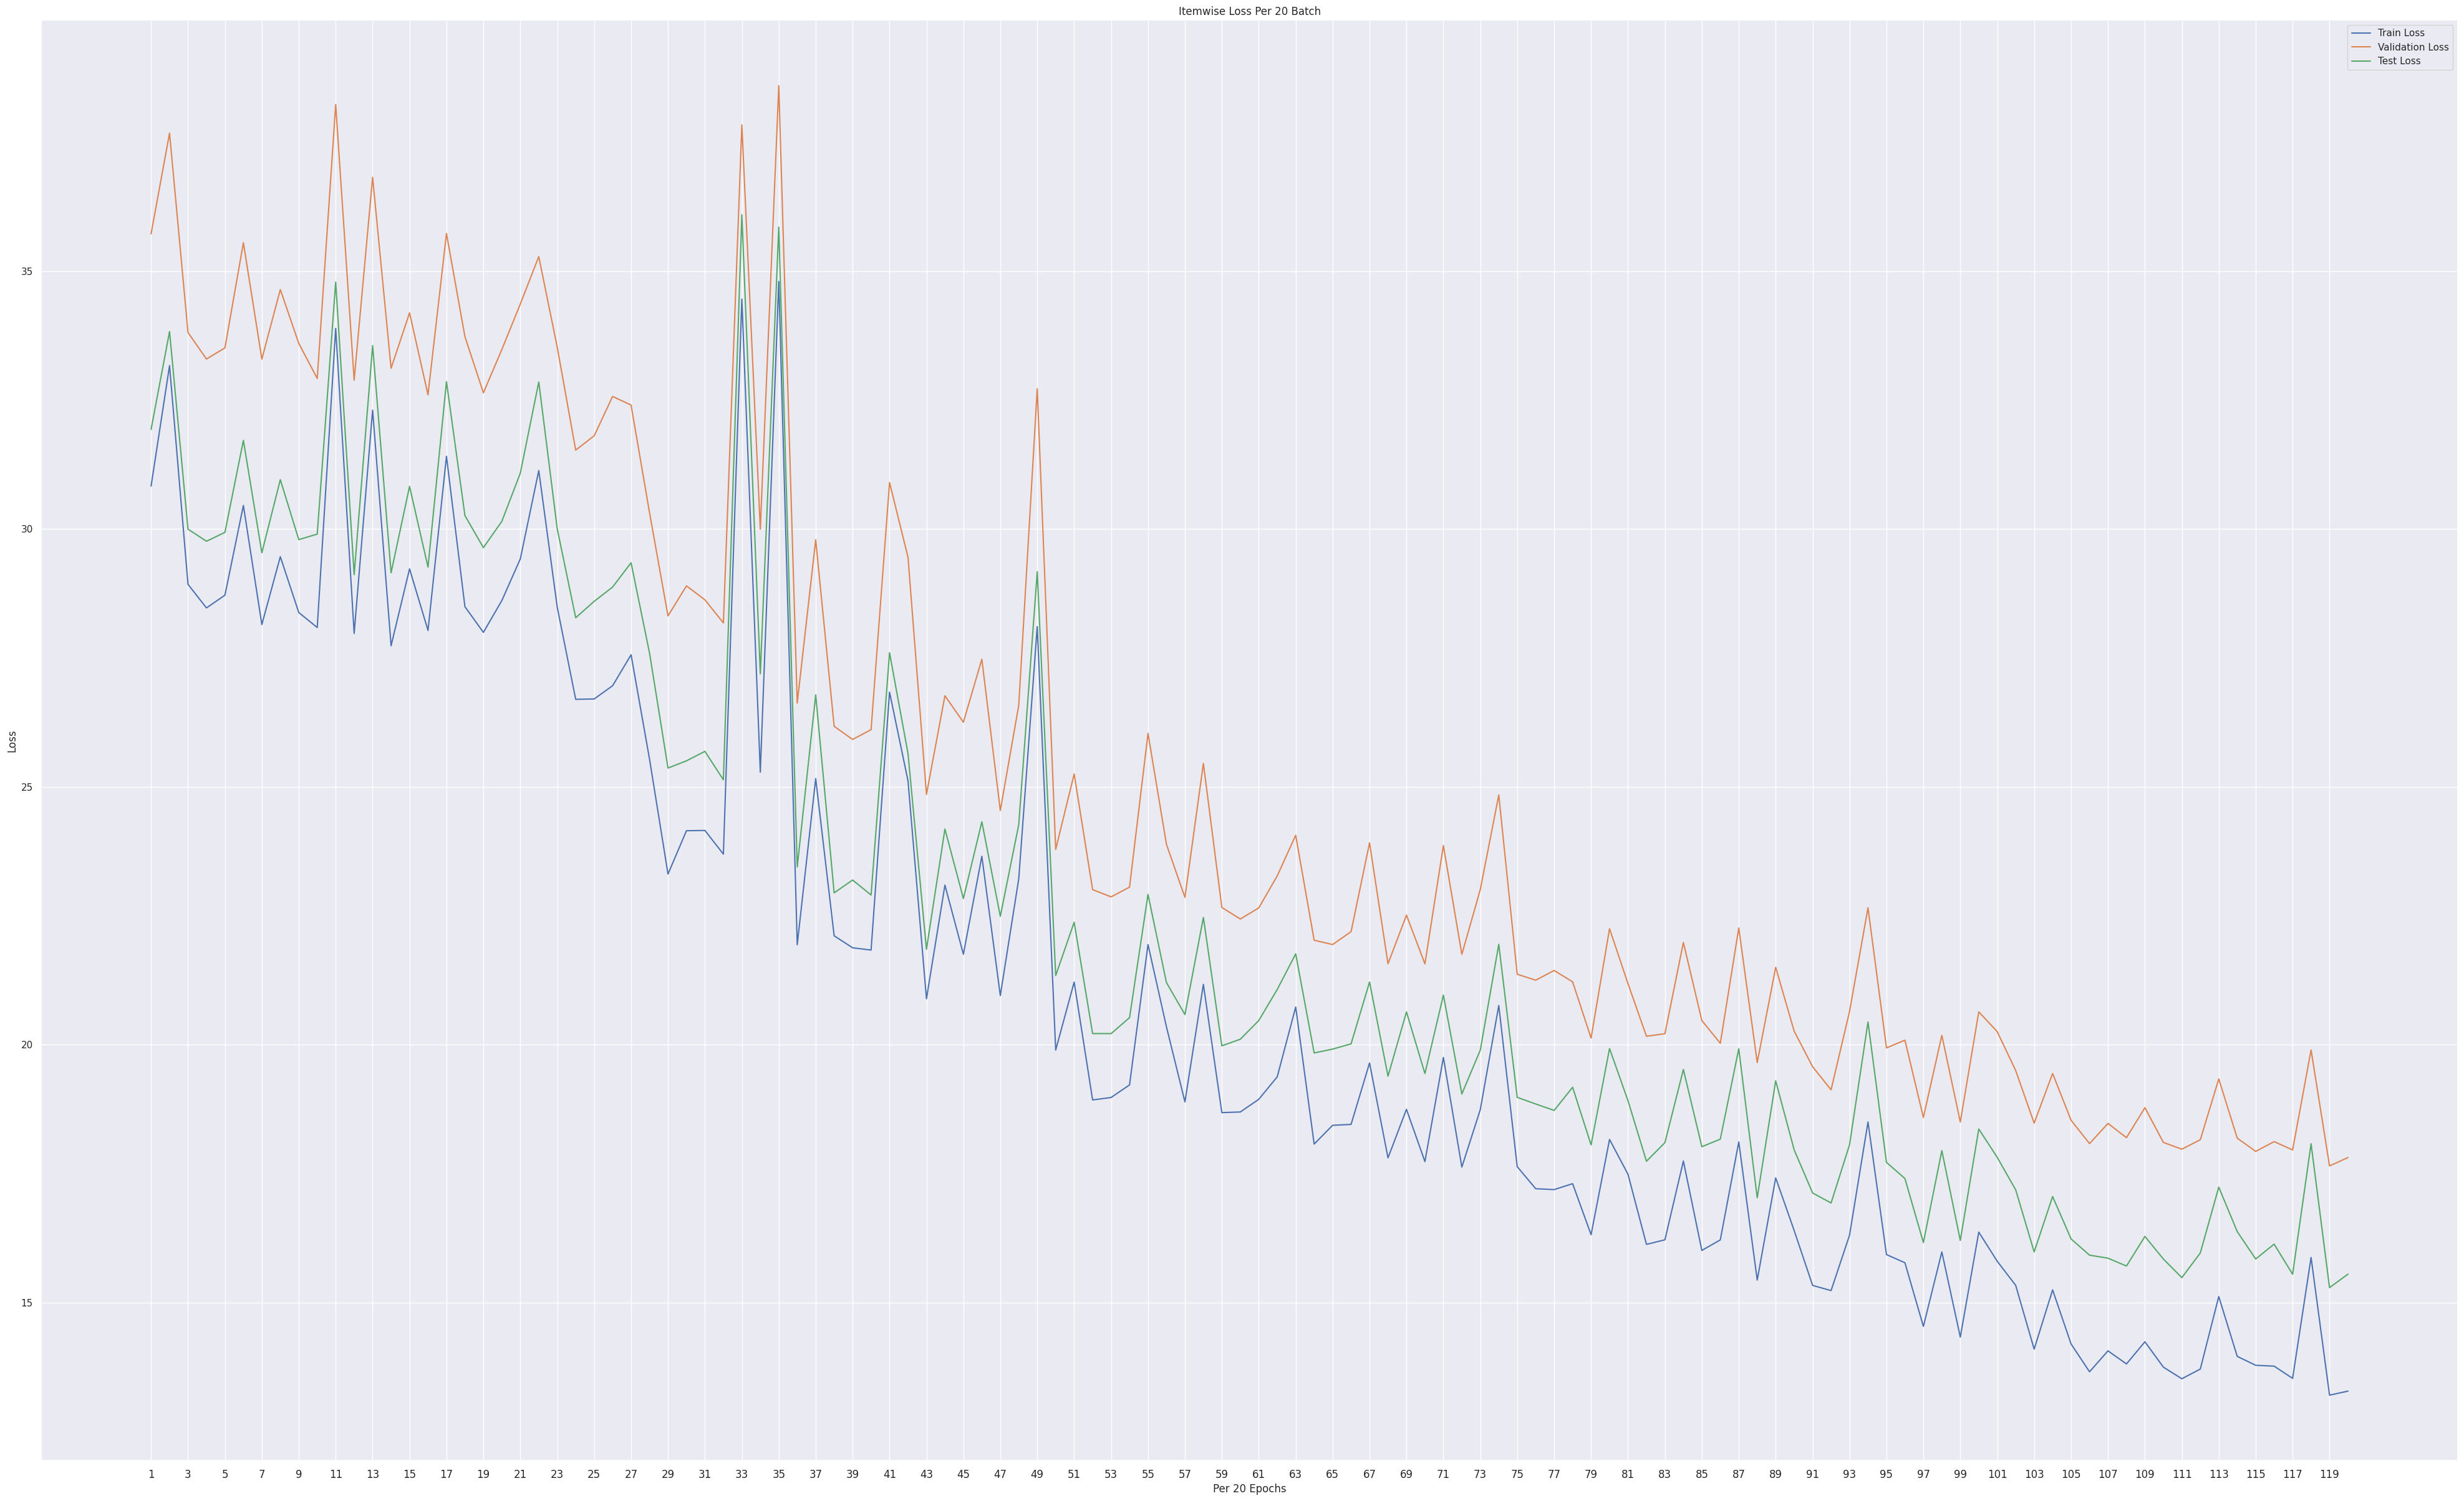

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_loss_left_SE: 6.049283027648926
	 avg_loss_right_SE: 5.842350006103516
	 avg_loss_left_AL: 1.7160953283309937
	 avg_loss_right_AL: 1.6814874410629272
	 avg_loss_left: 7.765378475189209
	 avg_loss_right: 7.523837566375732
	 avg_loss_SE: 11.891633033752441
	 avg_loss_AL: 3.397582769393921
	 avg_loss: 15.289216041564941
Fold 5
train_idx:  [ 1  2  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23]
test_idx:  [  0   3   7  21  24  25  26  63  67  84  86  91  93  94  99 100 112 126
 130 136]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Learning rate is to 0.01 now.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------------------------------------
Epoch 1/120
[Num of batch: 20] Avg train loss past 20 batch: 498.028 | Val LRClaRegTot loss this batch: 28.300 32.882 27.653 33.529 61.182 
[Num of batc

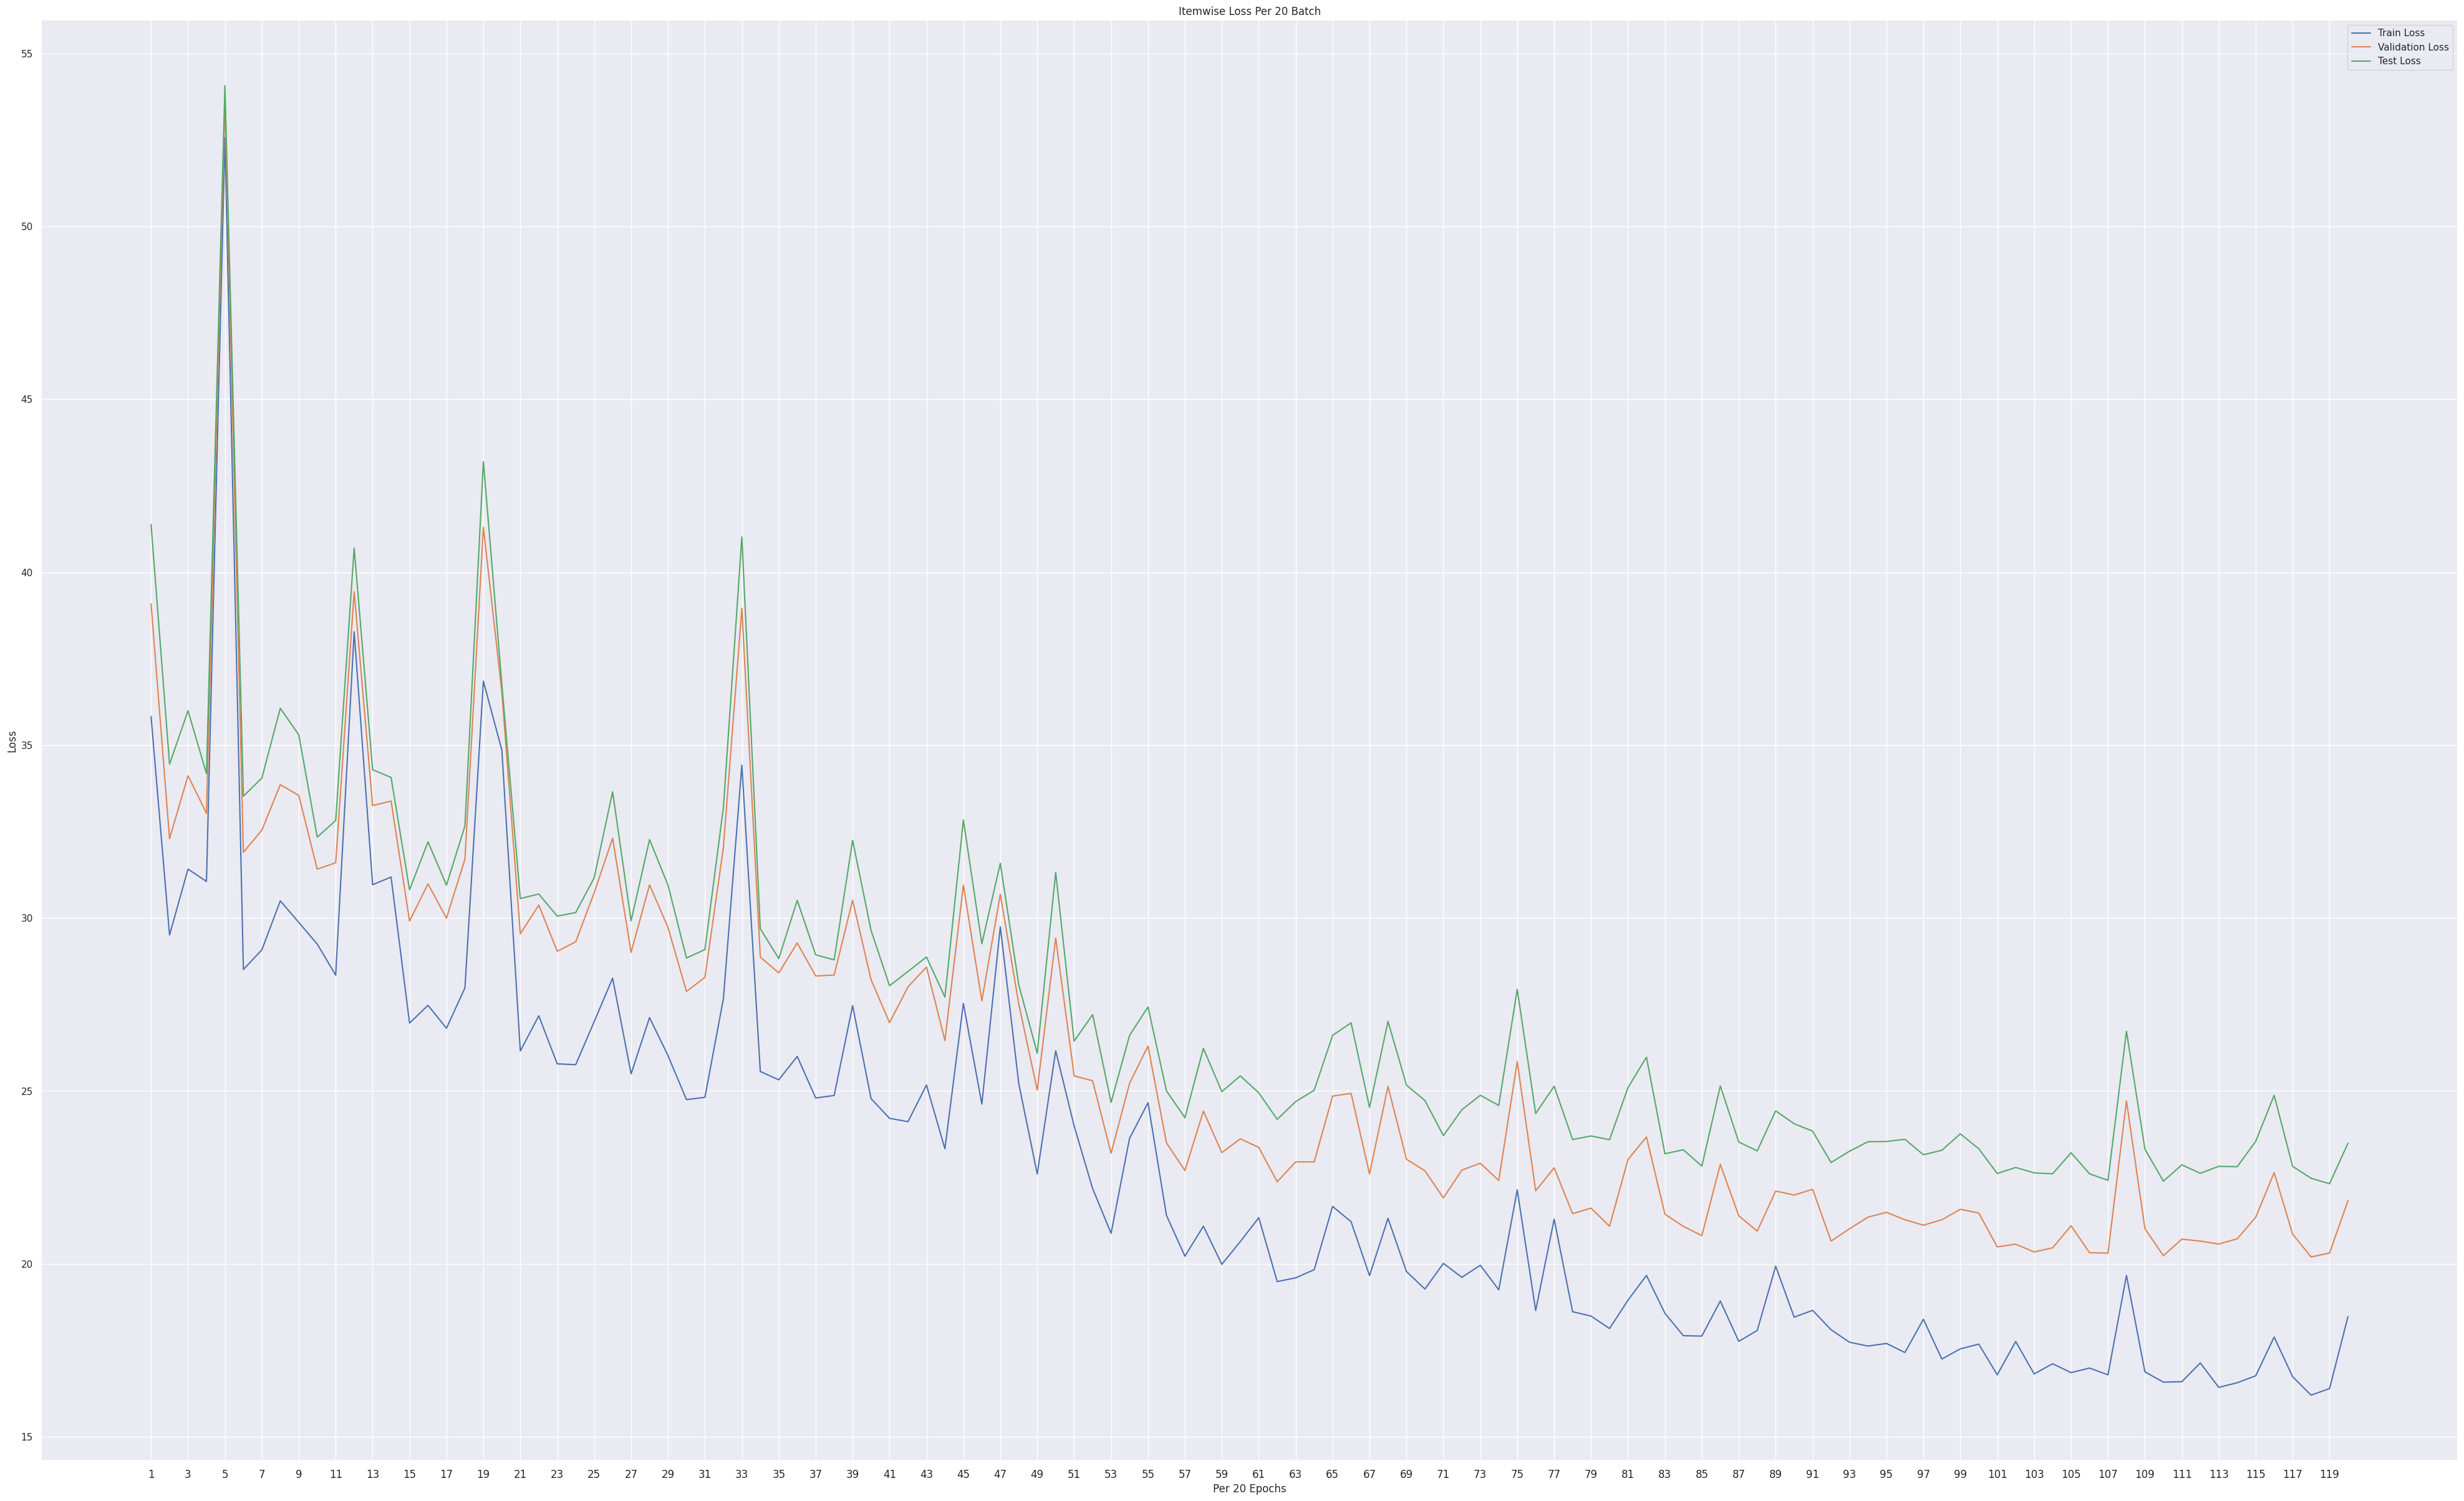

----------------------------------------------------------------------------------------------------
Performance of the BEST parameter setting on TEST set:
	 avg_loss_left_SE: 8.9277925491333
	 avg_loss_right_SE: 9.37990951538086
	 avg_loss_left_AL: 2.0985193252563477
	 avg_loss_right_AL: 2.068159580230713
	 avg_loss_left: 11.026311874389648
	 avg_loss_right: 11.448068618774414
	 avg_loss_SE: 18.307701110839844
	 avg_loss_AL: 4.1666789054870605
	 avg_loss: 22.474380493164062
Training complete in 7068m 49s


In [16]:
for seed in seed_list:
    # K fold
    since = time.time() # 运行起始时间
    
#     set_seed(seed)  # <<<<<< SEED <<<<<<
    
#     ds_XL = data_generation()

    # oucopula = OUCopula(resnet_output_size=resnet_output_size)

    kfold = KFold(n_splits = k, shuffle = True, random_state = seed)

    history = {'avg_loss_left_SE': [],
               'avg_loss_right_SE': [],
               'avg_loss_left_AL': [],
               'avg_loss_right_AL': [],
               'avg_loss_left': [],
               'avg_loss_right': [],
               'avg_loss_SE': [],
               'avg_loss_AL': [],
               'avg_loss': []}

    # Print at the top banner
    print('=' * 48)
    batch_num_per_epoch = X_length * train_ratio * (1 - validation_split) // batch_size
    print("    ooo " + " " + "u   u" + " " + " ccc "+ " " + " ooo "+ " " + "pppp "+ " "  + "u   u" + " " + "l  "+ " " + "   a")
    print("  o   o" + " " + "u   u" + " " + "c    "+ " " + "o   o"+ " " + "p   p"+ " "  + "u   u"+ " " + "l   "+ " " + "  a a")
    print(" o   o" + " " + "u   u" + " " + "c    "+ " " + "o   o"+ " " + "pppp "+ " "  + "u   u"+ " " + "l   "+ " " + " aaaaa")
    print(" ooo " + " " + " uuu " + " " + " ccc "+ " " + " ooo "+ " " + "p    "+ " "  + " uuu "+ " " + "llll"+ " " + "a     a")
    print('=' * 48)
    print(f"WorkID: {work_id}")
    current_time = datetime.now()
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    print("This experiment started at:", formatted_time)
    print('=' * 48)
    print("Important parameters: ")
    print("\tPython version:", sys.version)
    print("\tPytorch version: ", torch.__version__)
    print("\tBatch num per epoch: ", int(batch_num_per_epoch))
    print("\tlearning_rate: ", learning_rate)
    print("\tLearning rate decay every {} epoches.".format(lr_decay_step_size))
    print("Other parameters: ")
    print("\tRandom state KFold: ", seed)
    print("\tSeed: ", seed)
    print("\tKFold: ", k)
    print("\tBatch size: ", batch_size)
    print("\tNumber of epochs: ", num_epochs)
    print("\tSample size: ", X_length)
    # print("\tResNet输出的向量的维度: ", resnet_output_size)
    print("\tshuffle_train_set: ", shuffle_train_set)
    print("\ttrain_ratio (prop of train+val): ", train_ratio)
    print("\tvalidation_split: ", validation_split)
    print('=' * 48 + '\n')

    for fold, (train_idx, test_idx) in enumerate(kfold.split(np.arange(len(ds_XL)))):
        # For loss plot
        train_loss_batchwise_allfold = []
        val_loss_batchwise_allfold = []
        test_loss_batchwise_allfold = []

        print('=' * 60)
        print('Fold {}'.format(fold + 1))
        print('=' * 60)

        # Check train_idx, test_idx
        print("train_idx: ", train_idx[:20])
        print("test_idx: ", test_idx[:20])

        split = int(np.floor(validation_split * len(train_idx)))
        if shuffle_train_set:
            np.random.shuffle(train_idx)
        train_indices, val_indices = train_idx[split:], train_idx[:split]

        # train_sampler = SubsetRandomSampler(train_indices)
        # val_sampler = SubsetRandomSampler(val_indices)
        # test_sampler = SubsetRandomSampler(test_idx)

        # train_loader = DataLoader(ds_XL, batch_size=batch_size, sampler=train_sampler, shuffle=True, drop_last=True)
        # val_loader = DataLoader(ds_XL, batch_size=batch_size, sampler=val_sampler, shuffle=False, drop_last=True)
        # test_loader = DataLoader(ds_XL, batch_size=batch_size, sampler=test_sampler, shuffle=False, drop_last=True)

        # 上述代码会出现loss锯齿下降，使用下述代码不会出现，而是正常的锯齿下降
        train_dataset = Subset(ds_XL, train_indices)
        val_dataset = Subset(ds_XL, val_indices)
        test_dataset = Subset(ds_XL, test_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

        # 存储划分的数据集以便copula直接调用，从源头防止数据泄露！ @2023-09-27
        # warmup和copula我的batch size设置的也必须是一样的
        PATH_dl_train = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Train_Data_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.pt'
        torch.save(train_loader, PATH_dl_train)

        PATH_dl_val = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Val_Data_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.pt'
        torch.save(val_loader, PATH_dl_val)

        PATH_dl_test = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Test_Data_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.pt'
        torch.save(test_loader, PATH_dl_test)

        # network参数
        num_classes=[2,2]
        resnet_adapter = rsn10_adapter(num_classes).to(device)

        # Criterion
        # criterion_classification = nn.BCEWithLogitsLoss()
        # criterion_classification = nn.BCELoss()
        criterion_regression = nn.MSELoss()

        # Observe that all parameters are being optimized
        optimizer = optim.Adam(resnet_adapter.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        # Decay LR by a factor of ~ every ~ epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_prop)

        #====== 训练模型 ======
        resnet_adapter, train_loss_batchwise, val_loss_batchwise, test_loss_batchwise = train_model(resnet_adapter, criterion_regression, optimizer, exp_lr_scheduler, train_loader, val_loader, test_loader, num_epochs)
            # Now oucopula is the best parameter setting acquired in this fold
        # Record batchwise for all folds to plot the loss plot for whole training process
        train_loss_batchwise_allfold = [*train_loss_batchwise_allfold, *train_loss_batchwise]
        val_loss_batchwise_allfold = [*val_loss_batchwise_allfold, *val_loss_batchwise]
        test_loss_batchwise_allfold = [*test_loss_batchwise_allfold, *test_loss_batchwise]

        # Plot train val test loss
        print('-' * 100)
        print("Train, validation, & test loss per 20 epoch")
        plot_loss(batch_num_per_epoch, train_loss_batchwise_allfold, val_loss_batchwise_allfold, test_loss_batchwise_allfold)

        #====== 记录模型 ======
        # For 本地
        warm_up_PATH = f'/root/autodl-tmp/warmup loader files/WorkID{work_id}_Simu_Warmup_seed{seed}_fold{fold}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.pth'

        # Save the best parameter setting in warm_up_PATH
        torch.save(resnet_adapter.state_dict(), warm_up_PATH) # 模型提取 state_dict状态字典 并保存

        #====== 测试模型 ======
        oucopula_test = rsn10_adapter(num_classes).to(device) # 载入模型之前先初始化
        oucopula_test.load_state_dict(torch.load(warm_up_PATH)) # 载入模型：先从PATH载入状态字典，再load_state_dict

        # Test the best model in this fold
        loss_summary = test_stage(oucopula_test,  criterion_regression, test_loader)

        # history['Classification_accuracy'].append(Classification_accuracy)
        # history['Regression_loss'].append(Regression_loss)

        # Record the number into the dict
        for key, val in loss_summary.items():
            if torch.is_tensor(val):
                val = val.item()
            history[key].append(val)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # 输出到csv上的结果，我们只基于test dataset
    pd.DataFrame(history).to_csv(f'./Simu/WorkID{work_id}_Simu_Warmup_seed{seed}_X_length{X_length}_batchsize{batch_size}_num_epoch{num_epochs}.csv', index=True)
